# Skapa 2 modeller per ticker   
1. En modell som använder tomorrows close som target  
2. En modell som använder after tomorrows close som target   

In [15]:
from xgboost import XGBClassifier
from pytrends.request import TrendReq
import pandas as pd
from datetime import datetime as dt
import yfinance as yf
import ta
import pickle
import matplotlib.pyplot as plt 
import numpy as np
from sklearn.model_selection import GridSearchCV, cross_val_score
from sklearn.metrics import accuracy_score, confusion_matrix, roc_auc_score, precision_score, recall_score, f1_score    
from sklearn.pipeline import make_pipeline
from sklearn.impute import SimpleImputer
plt.style.use('fivethirtyeight')
pd.set_option('display.width', 200)
import streamlit as st


In [16]:
# print pandas version
print('pandas version: {}'.format(pd.__version__))
# print numpy version
print('numpy version: {}'.format(np.__version__))
# print matplotlib version
print('matplotlib version: {}'.format(plt.matplotlib.__version__))
# print yfinance version
print('yfinance version: {}'.format(yf.__version__))
# print pickle version
print('pickle version: {}'.format(pickle.format_version))

import ta
# print ta version
# print('ta version: {}'.format(ta.__version__))
# '0.10.2'
# print streamlit version
print('streamlit version: {}'.format(st.__version__))

import xgboost
print('xgboost version: {}'.format(xgboost.__version__))



pandas version: 1.4.3
numpy version: 1.22.3
matplotlib version: 3.5.2
yfinance version: 0.1.72
pickle version: 4.0
streamlit version: 1.10.0
xgboost version: 1.6.1


In [17]:
tickers = ['BTC-USD','ETH-USD','BCH-USD','ZRX-USD','XRP-USD']
ticker_names = ['Bitcoin','Ethereum','Bitcoin Cash','0X','Ripple']

In [18]:
# fill up a dataframe with all dates from 2015 up to today
def get_all_dates():
    start_date = dt(2005, 1, 1)
    end_date = dt.today()
    dates = pd.date_range(start_date, end_date)
    df = pd.DataFrame(index=dates)
    return df


## get Google Trends Bitcoin data


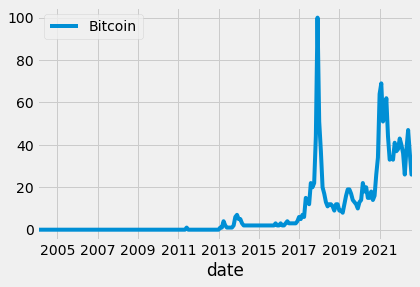

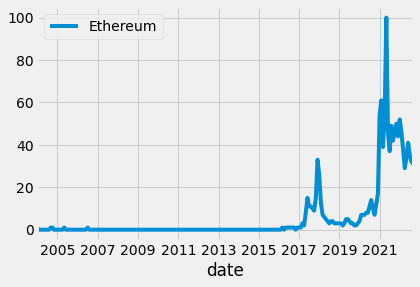

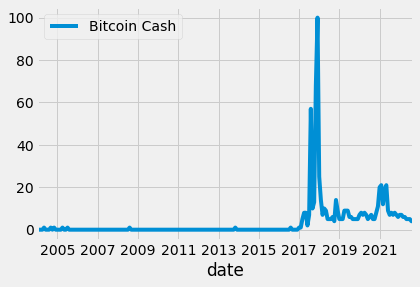

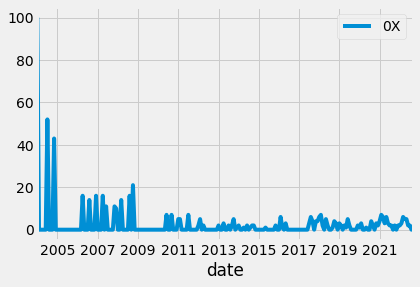

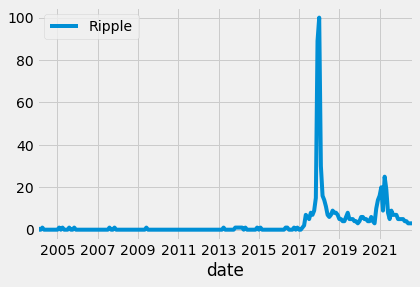

In [19]:
# get google trends data
from pytrends.request import TrendReq

pytrends = TrendReq(hl='en-US', tz=360)
df_trend = get_all_dates()
for ticker_name in ticker_names:
    pytrends.build_payload(kw_list=[ticker_name], cat=7, timeframe='all')
    df_temp = pytrends.interest_over_time()
    df_temp = df_temp.drop(columns=['isPartial'])
    df_temp.plot()
    df_trend = df_trend.merge(df_temp, how='left', left_index=True, right_index=True)
    df_trend[ticker_name] = df_trend[ticker_name].fillna(method='ffill')/30
    df_trend[ticker_name+'_30'] = df_trend[ticker_name].rolling(30, 1).mean()
    df_trend[ticker_name+'_90'] = df_trend[ticker_name].rolling(90, 1).mean()
    df_trend[ticker_name+'_250'] = df_trend[ticker_name].rolling(250, 1).mean()
    
df_trend = df_trend[ticker_names + [ticker_name+'_30' for ticker_name in ticker_names] + [ticker_name+'_90' for ticker_name in ticker_names] + [ticker_name+'_250' for ticker_name in ticker_names]]


In [20]:
df_trend.to_csv('google_trends.csv')
df_trend.tail()


,Bitcoin,Ethereum,Bitcoin Cash,0X,Ripple,Bitcoin_30,Ethereum_30,Bitcoin Cash_30,0X_30,Ripple_30,Bitcoin_90,Ethereum_90,Bitcoin Cash_90,0X_90,Ripple_90,Bitcoin_250,Ethereum_250,Bitcoin Cash_250,0X_250,Ripple_250
2022-09-26,0.866667,1.033333,0.133333,0.066667,0.1,0.866667,1.037778,0.133333,0.057778,0.1,0.997037,1.098148,0.145556,0.043704,0.1,1.162400,1.216933,0.177867,0.103067,0.127067
2022-09-27,0.866667,1.033333,0.133333,0.066667,0.1,0.866667,1.036667,0.133333,0.060000,0.1,0.989259,1.094444,0.145185,0.043704,0.1,1.160133,1.214133,0.177467,0.103067,0.126800
2022-09-28,0.866667,1.033333,0.133333,0.066667,0.1,0.866667,1.035556,0.133333,0.062222,0.1,0.981481,1.090741,0.144815,0.043704,0.1,1.157867,1.211333,0.177067,0.103067,0.126533
2022-09-29,0.866667,1.033333,0.133333,0.066667,0.1,0.866667,1.034444,0.133333,0.064444,0.1,0.977778,1.089259,0.144444,0.043704,0.1,1.155600,1.208533,0.176667,0.103067,0.126267
2022-09-30,0.866667,1.033333,0.133333,0.066667,0.1,0.866667,1.033333,0.133333,0.066667,0.1,0.974074,1.087778,0.144074,0.043704,0.1,1.153333,1.205733,0.176267,0.103067,0.126000


## skapa alla modellerna

In [21]:
df_trend.query('index>"2017-01-01"').head(35)

,Bitcoin,Ethereum,Bitcoin Cash,0X,Ripple,Bitcoin_30,Ethereum_30,Bitcoin Cash_30,0X_30,Ripple_30,Bitcoin_90,Ethereum_90,Bitcoin Cash_90,0X_90,Ripple_90,Bitcoin_250,Ethereum_250,Bitcoin Cash_250,0X_250,Ripple_250
2017-01-02,0.200000,0.033333,0.033333,0.0,0.0,0.137778,0.033333,0.002222,0.0,0.031111,0.113704,0.022222,0.000741,0.0,0.021481,0.108533,0.028933,0.004400,0.0124,0.016400
2017-01-03,0.200000,0.033333,0.033333,0.0,0.0,0.140000,0.033333,0.003333,0.0,0.030000,0.114815,0.022222,0.001111,0.0,0.021111,0.109067,0.029067,0.004533,0.0124,0.016400
2017-01-04,0.200000,0.033333,0.033333,0.0,0.0,0.142222,0.033333,0.004444,0.0,0.028889,0.115926,0.022222,0.001481,0.0,0.020741,0.109600,0.029200,0.004667,0.0124,0.016400
2017-01-05,0.200000,0.033333,0.033333,0.0,0.0,0.144444,0.033333,0.005556,0.0,0.027778,0.117037,0.022222,0.001852,0.0,0.020370,0.110133,0.029333,0.004800,0.0124,0.016400
2017-01-06,0.200000,0.033333,0.033333,0.0,0.0,0.146667,0.033333,0.006667,0.0,0.026667,0.118148,0.022222,0.002222,0.0,0.020000,0.110533,0.029333,0.004933,0.0120,0.016267
2017-01-07,0.200000,0.033333,0.033333,0.0,0.0,0.148889,0.033333,0.007778,0.0,0.025556,0.119259,0.022222,0.002593,0.0,0.019630,0.110933,0.029333,0.005067,0.0116,0.016133
2017-01-08,0.200000,0.033333,0.033333,0.0,0.0,0.151111,0.033333,0.008889,0.0,0.024444,0.120370,0.022222,0.002963,0.0,0.019259,0.111333,0.029333,0.005200,0.0112,0.016000
2017-01-09,0.200000,0.033333,0.033333,0.0,0.0,0.153333,0.033333,0.010000,0.0,0.023333,0.121481,0.022222,0.003333,0.0,0.018889,0.111733,0.029333,0.005333,0.0108,0.015867
2017-01-10,0.200000,0.033333,0.033333,0.0,0.0,0.155556,0.033333,0.011111,0.0,0.022222,0.122593,0.022222,0.003704,0.0,0.018519,0.112133,0.029333,0.005467,0.0104,0.015733
2017-01-11,0.200000,0.033333,0.033333,0.0,0.0,0.157778,0.033333,0.012222,0.0,0.021111,0.123704,0.022222,0.004074,0.0,0.018148,0.112533,0.029333,0.005600,0.0100,0.015600


In [22]:
def get_all(tickers):
    df = pd.DataFrame()
    for ticker in tickers:
        all_tickers = yf.download(ticker)
        df[ticker] = yf.download(ticker, period='max')['Close']
        
    df.index = pd.to_datetime(df.index)
    return df

In [23]:
df_org= get_all(tickers)

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


In [24]:
display(df_org.isna().sum())
df_org.shape

BTC-USD       0
ETH-USD    1149
BCH-USD    1149
ZRX-USD    1081
XRP-USD    1149
dtype: int64

(2936, 5)

In [25]:

def fit_predict(train, test, target, predictors, model, proba_val=None):
    model.fit(train[predictors], train[target])

    if proba_val:  # använd proba
        preds = model.predict_proba(test[predictors])[:, 1]
        preds[preds >= proba_val] = 1
        preds[preds < proba_val] = 0
    else:    # använd predict utan proba
        preds = model.predict(test[predictors])

    preds = pd.Series(preds, index=test.index, name="Predictions")
    combined = pd.concat([test[target], preds], axis=1)

    return combined



In [26]:
def backtest(data, target, model, predictors, proba_val=0.6, start=360, step=180):
    """"
    Args:
        data (DataFrame): Data to use for backtesting
        model: Tex RandomForestClassifier
        predictors: Features in data to use for backtesting
        proba_val (float): threshold för att få 1 annars 0 i predictions.
        start (int, optional): Hur många rader in i data skall vi starta testet. Defaults to 180.
        step (int, optional): Hur många rader skall vi ta i varje batch framåt. Defaults to 60.

    Returns:
        DataFrame: Två kolumner med true_y och prediktioner 
    """
    all_predictions = []

    for i in range(start, data.shape[0], step):
        train = data.iloc[0:i].copy()
        test = data.iloc[i:(i+step)].copy()
        predictions = fit_predict(
            train, test, target, predictors, model, proba_val=proba_val)
        all_predictions.append(predictions)

    return pd.concat(all_predictions)


def print_results(predictions, target):
    prec = precision_score(predictions[target], predictions["Predictions"])
    print(f'Fördelning av {target}: 1 vs 0:')
    print(predictions[target].value_counts() / predictions.shape[0])

    predictions.Predictions = predictions.Predictions.astype(int)
    print(predictions.value_counts())
    print(f"Precision:\t{prec:.4f}")
    return prec


### Beräkna predictors

In [27]:
def new_features(df_, ticker, target):
    df = df_.copy()
    # tidsintervall i dagar för rullande medelvärden
    # skulle helst ha med upp till 4 år men ETH har för få värden
    horizons = [2, 5, 60, 250]
    new_predictors = []
    df['stoch_k'] = ta.momentum.stochrsi_k(df[ticker], window=10)

    # Target
    # tomorrow's close price - alltså nästa dag
    df['Tomorrow'] = df[ticker].shift(-1)
    # after tomorrow's close price - alltså om två dagar
    df['After_tomorrow'] = df[ticker].shift(-2)
    df['y1'] = (df['Tomorrow'] > df[ticker]).astype(int)
    df['y2'] = (df['After_tomorrow'] > df[ticker]).astype(int)
    df.dropna(inplace=True)

    for horizon in horizons:
        rolling_averages = df.rolling(horizon, 1).mean()

        ratio_column = f"Close_Ratio_{horizon}"
        df[ratio_column] = df[ticker] / rolling_averages[ticker]

        trend_column = f"Trend_{horizon}"
        df[trend_column] = df.shift(1).rolling(horizon, 1).sum()[target]

        new_predictors += [ratio_column, trend_column]

    new_predictors.append('stoch_k')
    df = df.dropna()
    return df, new_predictors


In [28]:
pd.options.display.max_columns = 200    # default 20
pd.options.display.max_colwidth = 60  # default 50
pd.options.display.precision = 4      # default 6
print(tickers[0])
df, new_predictors = new_features(df_org, tickers[0], 'y1')
df[new_predictors+['y1']]


BTC-USD


,Close_Ratio_2,Trend_2,Close_Ratio_5,Trend_5,Close_Ratio_60,Trend_60,Close_Ratio_250,Trend_250,stoch_k,y1
Date,,,,,,,,,,
2017-11-10,0.9618,0.0,0.9618,0.0,0.9618,0.0,0.9618,0.0,0.1433,0
2017-11-11,0.9799,0.0,0.9480,0.0,0.9480,0.0,0.9480,0.0,0.0000,0
2017-11-12,0.9669,0.0,0.9130,0.0,0.9130,0.0,0.9130,0.0,0.0000,1
2017-11-13,1.0487,1.0,1.0052,1.0,1.0052,1.0,1.0052,1.0,0.0914,1
2017-11-14,1.0058,2.0,1.0329,2.0,1.0140,2.0,1.0140,2.0,0.1926,1
...,...,...,...,...,...,...,...,...,...,...
2022-09-24,0.9906,0.0,0.9958,1.0,0.8811,27.0,0.6091,120.0,0.7312,0
2022-09-25,0.9964,0.0,0.9896,1.0,0.8777,26.0,0.6066,119.0,0.5819,1
2022-09-26,1.0111,1.0,1.0046,2.0,0.9005,26.0,0.6220,120.0,0.6179,0


### Vi använder XGBoost

In [29]:
xgb_params = {'gamma': 0.7, 'learning_rate': 0.005, 'max_depth': 7, 'min_child_weight': 3, 'n_estimators': 200, 'subsample': 0.4}
from xgboost import XGBClassifier
xgb = XGBClassifier(**xgb_params, random_state=2022, n_jobs=-1)

predictions_xgb = backtest(df, 'y1', xgb, new_predictors, proba_val= 0.6, step=30)
xgb_try = print_results(predictions_xgb,'y1')

pd.DataFrame(xgb.feature_importances_,columns=['importance'], index=new_predictors).sort_values(by='importance', ascending=False)

Fördelning av y1: 1 vs 0:
1    0.5181
0    0.4819
Name: y1, dtype: float64
y1  Predictions
1   0              678
0   0              631
1   1               51
0   1               47
dtype: int64
Precision:	0.5204


,importance
Trend_5,0.1172
Close_Ratio_60,0.1171
Close_Ratio_2,0.1169
Close_Ratio_5,0.1139
Close_Ratio_250,0.1121
stoch_k,0.1117
Trend_60,0.1059
Trend_250,0.1053
Trend_2,0.0999


In [30]:
df

,BTC-USD,ETH-USD,BCH-USD,ZRX-USD,XRP-USD,stoch_k,Tomorrow,After_tomorrow,y1,y2,Close_Ratio_2,Trend_2,Close_Ratio_5,Trend_5,Close_Ratio_60,Trend_60,Close_Ratio_250,Trend_250
Date,,,,,,,,,,,,,,,,,,
2017-11-10,6618.1401,299.2530,1007.4200,0.1972,0.2065,0.1433,6357.6001,5950.0698,0,0,0.9618,0.0,0.9618,0.0,0.9618,0.0,0.9618,0.0
2017-11-11,6357.6001,314.6810,1340.4500,0.1972,0.2104,0.0000,5950.0698,6559.4902,0,1,0.9799,0.0,0.9480,0.0,0.9480,0.0,0.9480,0.0
2017-11-12,5950.0698,307.9080,1388.8600,0.1879,0.1973,0.0000,6559.4902,6635.7500,1,1,0.9669,0.0,0.9130,0.0,0.9130,0.0,0.9130,0.0
2017-11-13,6559.4902,316.7160,1353.9900,0.1969,0.2034,0.0914,6635.7500,7315.5400,1,1,1.0487,1.0,1.0052,1.0,1.0052,1.0,1.0052,1.0
2017-11-14,6635.7500,337.6310,1273.5300,0.1993,0.2098,0.1926,7315.5400,7871.6899,1,1,1.0058,2.0,1.0329,2.0,1.0140,2.0,1.0140,2.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-09-24,18937.0117,1317.9933,117.9208,0.2729,0.4887,0.7312,18802.0977,19222.6719,0,1,0.9906,0.0,0.9958,1.0,0.8811,27.0,0.6091,120.0
2022-09-25,18802.0977,1294.2168,113.5001,0.2688,0.4926,0.5819,19222.6719,19110.5469,1,1,0.9964,0.0,0.9896,1.0,0.8777,26.0,0.6066,119.0
2022-09-26,19222.6719,1335.3202,116.2026,0.2679,0.4677,0.6179,19110.5469,19426.7207,0,1,1.0111,1.0,1.0046,2.0,0.9005,26.0,0.6220,120.0


Loop öve all tickers och skapa 2 modeller  
    En mot y1 och en mot y2  
    spara båda modellerna  
Totalt 2 modeller per ticker (= 10 st)    

Modellens namn:  
    ticker[:3]_y1  
    ticker[:3]_y2

In [31]:
def add_google_trends(df_, df_trend, ticker, new_predictors):
    df = df_.copy()
    
    lookup = {'BTC-USD': 'Bitcoin', 'ETH-USD': 'Ethereum', 'BCH-USD': 'Bitcoin Cash', 'XRP-USD': 'Ripple', 'ZRX-USD': '0X'}
    ticker_namn = lookup[ticker]
    
    df[ticker_namn + '_goog30'] = df_trend[ticker_namn + '_30']
    new_predictors.append(ticker_namn + '_goog30')
    df[ticker_namn + '_goog90'] = df_trend[ticker_namn + '_90']
    new_predictors.append(ticker_namn + '_goog90')
    df[ticker_namn + '_goog250'] = df_trend[ticker_namn + '_250']
    new_predictors.append(ticker_namn + '_goog250')
    
    return df, new_predictors

for enum, ticker in enumerate(tickers):
    namn = ticker[:3]
    print(namn)
    df, new_predictors = new_features(df_org, ticker, 'y1')
    df, new_predictors = add_google_trends(df, df_trend, ticker, new_predictors)
    predictions_xgb = backtest(df, 'y1', xgb, new_predictors, proba_val= 0.55, step=30)
    xgb_try = print_results(predictions_xgb,'y1')
    display(pd.DataFrame(xgb.feature_importances_,columns=['importance'], index=new_predictors).sort_values(by='importance', ascending=False))
    
    xgb.fit(df[new_predictors], df['y1'])
    # pickle dump model
    pickle.dump(xgb, open(f'{namn}_y1.pkl', 'wb'))
    
    df, new_predictors = new_features(df_org, ticker, 'y2')
    df, new_predictors = add_google_trends(df, df_trend, ticker, new_predictors)
    predictions_xgb = backtest(df, 'y2', xgb, new_predictors, proba_val=0.55, step=30)
    xgb_try = print_results(predictions_xgb,'y2')
    display(pd.DataFrame(xgb.feature_importances_,columns=['importance'], index=new_predictors).sort_values(by='importance', ascending=False))
    xgb.fit(df[new_predictors], df['y2'])
    # pickle dump model
    pickle.dump(xgb, open(f'{namn}_y2.pkl', 'wb'))
    

BTC
Fördelning av y1: 1 vs 0:
1    0.5181
0    0.4819
Name: y1, dtype: float64
y1  Predictions
1   0              531
0   0              505
1   1              198
0   1              173
dtype: int64
Precision:	0.5337


,importance
Bitcoin_goog250,0.0918
Trend_5,0.0894
Close_Ratio_2,0.0873
Close_Ratio_5,0.0859
Close_Ratio_60,0.0851
Bitcoin_goog90,0.0851
Close_Ratio_250,0.0850
Bitcoin_goog30,0.0849
stoch_k,0.0814
Trend_60,0.0779


Fördelning av y2: 1 vs 0:
1    0.5295
0    0.4705
Name: y2, dtype: float64
y2  Predictions
0   0              506
1   0              456
    1              289
0   1              156
dtype: int64
Precision:	0.6494


,importance
Trend_2,0.2012
Close_Ratio_5,0.0909
Close_Ratio_2,0.0822
Trend_5,0.0813
Bitcoin_goog250,0.0754
Close_Ratio_60,0.0725
stoch_k,0.0678
Close_Ratio_250,0.0675
Bitcoin_goog90,0.0674
Trend_60,0.0666


ETH
Fördelning av y1: 1 vs 0:
1    0.5185
0    0.4815
Name: y1, dtype: float64
y1  Predictions
1   0              563
0   0              544
1   1              165
0   1              132
dtype: int64
Precision:	0.5556


,importance
Close_Ratio_2,0.0950
Ethereum_goog90,0.0875
stoch_k,0.0860
Ethereum_goog250,0.0857
Ethereum_goog30,0.0834
Close_Ratio_5,0.0827
Close_Ratio_60,0.0812
Close_Ratio_250,0.0810
Trend_2,0.0809
Trend_60,0.0790


Fördelning av y2: 1 vs 0:
1    0.5228
0    0.4772
Name: y2, dtype: float64
y2  Predictions
0   0              527
1   0              462
    1              272
0   1              143
dtype: int64
Precision:	0.6554


,importance
Trend_2,0.1858
Close_Ratio_2,0.0975
Close_Ratio_5,0.0903
Ethereum_goog30,0.0733
Ethereum_goog250,0.0716
Trend_5,0.0701
Trend_250,0.0695
Ethereum_goog90,0.0695
Trend_60,0.0687
stoch_k,0.0684


BCH
Fördelning av y1: 1 vs 0:
0    0.5103
1    0.4897
Name: y1, dtype: float64
y1  Predictions
0   0              615
1   0              575
    1              111
0   1              100
dtype: int64
Precision:	0.5261


,importance
Close_Ratio_2,0.0954
Trend_2,0.0904
Close_Ratio_5,0.0849
Bitcoin Cash_goog30,0.0848
Close_Ratio_250,0.0840
Trend_60,0.0824
Close_Ratio_60,0.0814
stoch_k,0.0813
Bitcoin Cash_goog90,0.0807
Bitcoin Cash_goog250,0.0787


Fördelning av y2: 1 vs 0:
0    0.5161
1    0.4839
Name: y2, dtype: float64
y2  Predictions
0   0              605
1   0              449
    1              229
0   1              118
dtype: int64
Precision:	0.6599


,importance
Trend_2,0.1998
Close_Ratio_2,0.1045
Close_Ratio_5,0.0973
Trend_60,0.0687
Bitcoin Cash_goog30,0.0684
Trend_5,0.0677
Bitcoin Cash_goog250,0.0672
Close_Ratio_250,0.0667
Trend_250,0.0662
stoch_k,0.0654


ZRX
Fördelning av y1: 1 vs 0:
0    0.5053
1    0.4947
Name: y1, dtype: float64
y1  Predictions
0   0              641
1   0              621
    1               73
0   1               68
dtype: int64
Precision:	0.5177


,importance
0X_goog90,0.0925
Close_Ratio_2,0.0909
Close_Ratio_60,0.0858
Trend_60,0.0850
0X_goog250,0.0837
Close_Ratio_5,0.0827
stoch_k,0.0824
0X_goog30,0.0810
Trend_5,0.0802
Close_Ratio_250,0.0798


Fördelning av y2: 1 vs 0:
0    0.526
1    0.474
Name: y2, dtype: float64
y2  Predictions
0   0              661
1   0              525
    1              140
0   1               77
dtype: int64
Precision:	0.6452


,importance
Trend_2,0.1814
Trend_5,0.0925
Close_Ratio_2,0.0880
Close_Ratio_5,0.0880
0X_goog90,0.0749
Close_Ratio_250,0.0733
0X_goog30,0.0721
Trend_250,0.0690
stoch_k,0.0663
0X_goog250,0.0663


XRP
Fördelning av y1: 1 vs 0:
0    0.5057
1    0.4943
Name: y1, dtype: float64
y1  Predictions
0   0              638
1   0              583
    1              111
0   1               72
dtype: int64
Precision:	0.6066


,importance
Close_Ratio_2,0.0996
Trend_2,0.0853
Close_Ratio_5,0.0852
Close_Ratio_250,0.0844
Ripple_goog90,0.0837
Ripple_goog250,0.0828
Close_Ratio_60,0.0828
Trend_60,0.0817
Trend_5,0.0808
Ripple_goog30,0.0790


Fördelning av y2: 1 vs 0:
0    0.5256
1    0.4744
Name: y2, dtype: float64
y2  Predictions
0   0              652
1   0              515
    1              151
0   1               86
dtype: int64
Precision:	0.6371


,importance
Trend_2,0.1807
Close_Ratio_2,0.0976
Close_Ratio_5,0.0883
Trend_5,0.0789
Close_Ratio_60,0.0772
Ripple_goog90,0.0721
stoch_k,0.0710
Ripple_goog250,0.0686
Trend_250,0.0676
Close_Ratio_250,0.0676


In [32]:
df[new_predictors]

,Close_Ratio_2,Trend_2,Close_Ratio_5,Trend_5,Close_Ratio_60,Trend_60,Close_Ratio_250,Trend_250,stoch_k,Ripple_goog30,Ripple_goog90,Ripple_goog250
Date,,,,,,,,,,,,
2017-11-13,1.0152,1.0,1.0152,1.0,1.0152,1.0,1.0152,1.0,0.2478,0.3867,0.3007,0.2089
2017-11-14,1.0154,2.0,1.0309,2.0,1.0309,2.0,1.0309,2.0,0.3038,0.3933,0.3033,0.2108
2017-11-15,1.0074,2.0,1.0343,3.0,1.0343,3.0,1.0343,3.0,0.4260,0.4000,0.3059,0.2127
2017-11-16,1.0322,2.0,1.0808,4.0,1.0808,4.0,1.0808,4.0,0.5418,0.4067,0.3085,0.2145
2017-11-17,0.9988,2.0,1.0491,5.0,1.0644,5.0,1.0644,5.0,0.6103,0.4133,0.3111,0.2164
...,...,...,...,...,...,...,...,...,...,...,...,...
2022-09-24,0.9815,1.0,1.0657,4.0,1.3400,35.0,0.9205,119.0,0.9445,0.1000,0.1000,0.1276
2022-09-25,1.0040,0.0,1.0391,3.0,1.3425,34.0,0.9297,119.0,0.8627,0.1000,0.1000,0.1273
2022-09-26,0.9740,0.0,0.9578,2.0,1.2691,33.0,0.8844,119.0,0.6622,0.1000,0.1000,0.1271
